# Тeматическое моделирование

In [1]:
! pip install spacy -q
! python -m spacy download ru_core_news_sm -q


2023-06-29 18:22:25.259121: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-29 18:22:27.196806: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 15.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')


Подключаем библиотеки.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import re
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

import json

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Exploratory data analysis

Укажем путь к файлу.

In [3]:
!gdown 1WbUGXxfXmWnBy93DdFQdT28s8eZfZSjj

Downloading...
From: https://drive.google.com/uc?id=1WbUGXxfXmWnBy93DdFQdT28s8eZfZSjj
To: /content/clean_posts.csv
100% 3.79M/3.79M [00:00<00:00, 212MB/s]


Загрузим данные в dataframe.

In [4]:
df = pd.read_csv('/content/clean_posts.csv')
df.head()

,account_link,search_keywords,name,title,works_at,intro,experience,place,posts_cnt,post_text,reaction_cnt,comments_cnt,repost_cnt
0,https://www.linkedin.com/in/varvara-kulmeteva-...,senior web developer,Varvara Kulmeteva,Senior Web Developer - IBS InfinitySoft,IBS,Навыки: ReactJS · JavaScript · HTML · CSSНавык...,10.0,"Москва, Московская область, Россия",0,NaN,NaN,NaN,NaN
1,https://www.linkedin.com/in/rauventa,senior frontend,Ilya Moiseenko,"LOOKING FOR ""Senior/Lead Frontend (React) Deve...",Centicore,"Ilya, React Developer from Moscow.Ilya, React ...",8.0,"Москва, Москва, Россия",1,Я только что получил(а) значок за навык «JavaS...,1.0,NaN,NaN
2,https://www.linkedin.com/in/denis-kuchkildin,middle data analyst,Denis Kuchkildin,Data Analyst at X5 Group,X5 Group,I have a strong engineering background and mor...,6.0,"Москва, Москва, Россия",1,Hi everyone - I am looking for a new role and ...,NaN,NaN,NaN
3,https://www.linkedin.com/in/ACoAAC4yJzEB4TjXkJ...,senior ML engineer,Ian Silantev,MSc Data Science in University of East London ...,Neurospot,"Absolutely in love with Data Science, AI and M...",2.0,"Тбилиси, Грузия",0,NaN,NaN,NaN,NaN
4,https://www.linkedin.com/in/oleg-malyshkin,senior test engineer,Oleg Malyshkin,Senior Test Automation Engineer at GlobalLogic,NaN,"Hi everyone, I am Oleg Malyshkin - Senior Test...",4.0,"Киев, Киев, Украина",9,Finding a job for trainees and juniors is a ch...,1.0,NaN,NaN


Оставим только посты на русском.

In [5]:
df = df[df.post_text.astype('str').map(lambda x: x.isascii())==False]

Посмотрим на размер выборки.

In [6]:
df.shape

(709, 13)

Посчитаем колличество уникальных имен ссылок на аккаунты.

In [7]:
df.account_link.nunique()

188

787 ссылок на аккаунты.

Посмотрим на места проживания пользователей. оТфитруем только тех, кто живет в РФ.

In [8]:
df.place.unique()

array(['Москва, Москва, Россия', 'Киев, Киев, Украина',
       'Батайск, Ростовская область, Россия', 'Россия',
       'Лобня, Московская область, Россия',
       'Республика Татарстан, Россия',
       'Пушкино, Московская область, Россия', 'Аргентина',
       'Санкт-Петербург, Санкт-Петербург, Россия',
       'Ташкентская область, Узбекистан',
       'Химки, Московская область, Россия',
       'Рыбинск, Ярославская область, Россия',
       'Москва, Московская область, Россия',
       'Ставрополь, Ставропольский край, Россия',
       'Краснодар, Краснодарский край, Россия', 'Бали, Индонезия',
       'Москва, Россия', 'Пермь, Пермский край, Россия',
       'Ярославль, Ярославская область, Россия',
       'Нижний Новгород, Нижегородская область, Россия',
       'Будва, Черногория', 'Ростов-на-Дону, Ростовская область, Россия',
       'Алматы, Казахстан', 'Екатеринбург, Свердловская область, Россия',
       'Уфа, Республика Башкортостан, Россия', 'Сербия',
       'Домодедово, Московская о

In [9]:
foreign = ['Тбилиси, Грузия', 'Киев, Киев, Украина',
       'Соединённое Королевство',  'Никосия, Никосия, Кипр',
     'Аргентина',
       'Республика Беларусь', 'Сербия',
       'Нур-Султан, Казахстан',
       'Ташкентская область, Узбекистан',
       'Нью-Касл, Делавэр, Соединенные Штаты Америки', 'Бали, Индонезия',
       'Бишкек, Киргизия',
       'Будва, Черногория',
       'Белград, Сербия', 'Алматы, Казахстан',
       'Арона, Канарские Острова, Испания',
       'Центральный округ, Израиль',
       'Агломерация Генуи', 'Лимасол, Кипр', 'Батуми, Грузия',
       'Эдмонтон, Альберта, Канада', 'Узбекистан',
       'Область залива Сан-Франциско', 'Турция',
       'София, Sofia City, Болгария',
       'Хургада, Красное Море, Египет', 'Измир, Турция', 'Лимасол, Лимасол, Кипр', 'Израиль',
       'Подгорица, Черногория', 'Ереван, Ереван, Армения',
       'Берлин, Берлин, Германия',
       'Варшава, Мазовецкое воеводство, Польша', 'Тель-Авивский округ, Израиль',
       'Бернаби, Британская Колумбия, Канада', 'Бангкок, Таиланд',
       'Нью-Йорк, Нью-Йорк, Соединенные Штаты Америки', 'Никосия, Кипр', 'Соединенные Штаты Америки',
       'Агломерация Кирова', 'Голландия',
       'Кривой Рог, Днепропетровская область, Украина',
       'Budge Budge-I, Западная Бенгалия, Индия',
       'Тель-Авив, Тель-Авивский округ, Израиль',
       'Дубай, Объединённые Арабские Эмираты', 'Гданьск, Померания, Польша',
       'Варанаси, Уттар-Прадеш, Индия',
       'Ричмонд, Англия, Соединённое Королевство',
       'Харьков, Харьковская область, Украина', 'Казахстан',
       'Стокгольм, Лен Стокгольм, Швеция',
       'Шарджа, Объединённые Арабские Эмираты', 'Ереван, Армения',
       'Львов, Львовская область, Украина', 'Гонконг (Китай)',
       'Сан-Хосе, Калифорния, Соединенные Штаты Америки',
       'Нагпур, Махараштра, Индия', 'Нови Сад, Воеводина, Сербия', 'Алжир',
       'Дубай, Дубай, Объединённые Арабские Эмираты', 'Филиппины', 'Агломерация Парижа',
       'Агломерация Днепра', 'Ташкент, Узбекистан',
       'Агломерация Мельбурна', 'Таламанка, Лимон, Коста-Рика',
       'Лондон, Англия, Соединённое Королевство', 'Минск, Республика Беларусь']

In [10]:
df = df.query('place not in @foreign')

In [11]:
df.shape

(608, 13)

3/4 строк мы потеряли.

**Посмотрим на числянные признаки.**

In [12]:
df.describe()

,experience,posts_cnt,reaction_cnt,comments_cnt,repost_cnt
count,607.000000,608.000000,529.000000,288.000000,290.000000
mean,13.314662,32.485197,4.884688,3.815972,4.244828
std,74.598097,48.707679,2.653602,2.465968,2.704358
min,0.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,4.000000,2.000000,2.000000,2.000000
50%,5.000000,10.000000,5.000000,3.000000,4.000000
75%,9.000000,37.000000,7.000000,6.000000,7.000000
max,853.000000,158.000000,9.000000,9.000000,9.000000


# Experience - опыт.

Очевидно, что есть выбросы по опыту. Ну никак больше 100 лет у нас не может быть в этих данных. Тем более 1432 лет. Данный признак мы не оцениваем. Посмотрим сколько таких строк.

In [13]:
len(df[df.experience>100])

7

Посмотрим, есть ли посты у людей сопытом более 100 лет.

In [14]:
df[df.experience>100].posts_cnt.value_counts(dropna=False)

4    4
8    3
Name: posts_cnt, dtype: int64

Посты есть, не будем их удалять. Но посмотри на распределение без этих значений.

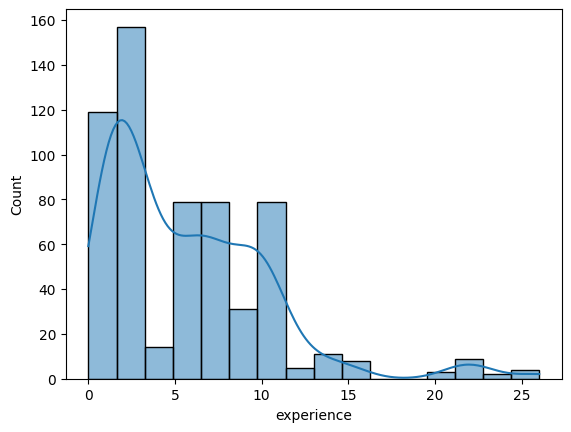

In [15]:
sns.histplot(df.query('experience<100')['experience'], kde=True)
plt.show()

Как видно, большинство пользователей с опытом 10 лет. Резкий пик у 12. И еще более резкий спад. Людей с опытом более 30 лет практически нет.

# posts_cnt - кол-во постов.

Посмотрим на распредление по кол-ву постов.

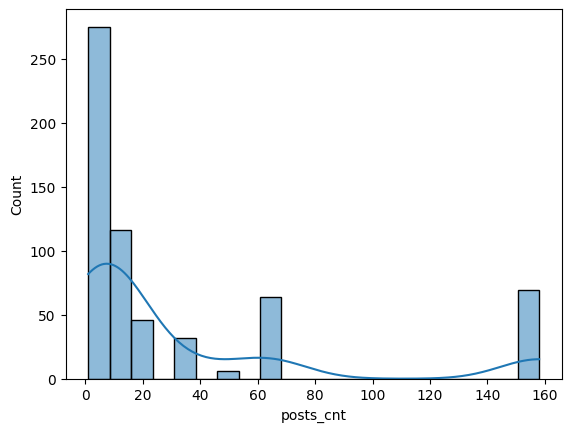

In [16]:
sns.histplot(df.posts_cnt, kde=True)
plt.show()

Большинство профилей не имеют постов. Есть единичные пики у 150 и 300. Посмотрим, сколько у нас таких пользователей.

In [17]:
df[df.posts_cnt>100]['name'].nunique()

1

2 пользователя с таким кол-вом постов.

# reaction_cnt - кол-во реакций.

Посмотрим на распределение reaction_cnt.

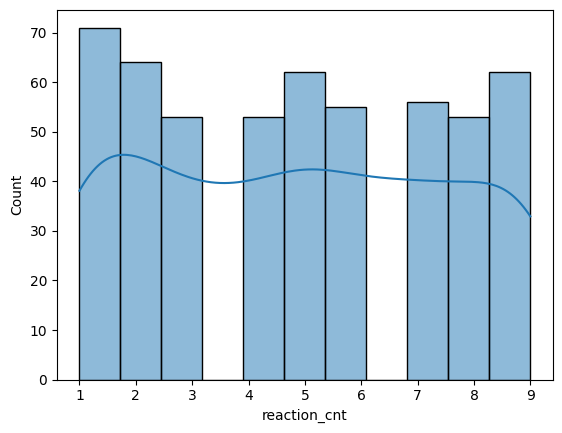

In [18]:
sns.histplot(df.reaction_cnt, kde=True)
plt.show()

Здесь график больше похож на равномерное распределение. Есть и провалы, конечно. Посмотрим сколько постов без реакций.

In [19]:
df.reaction_cnt.value_counts(dropna=False)

NaN    79
1.0    71
2.0    64
9.0    62
5.0    62
7.0    56
6.0    55
3.0    53
4.0    53
8.0    53
Name: reaction_cnt, dtype: int64

Получается, что около половины постов без реакций.

# comments_cnt - кол-во комментариев.

Посмотрим на распределение reaction_cnt.

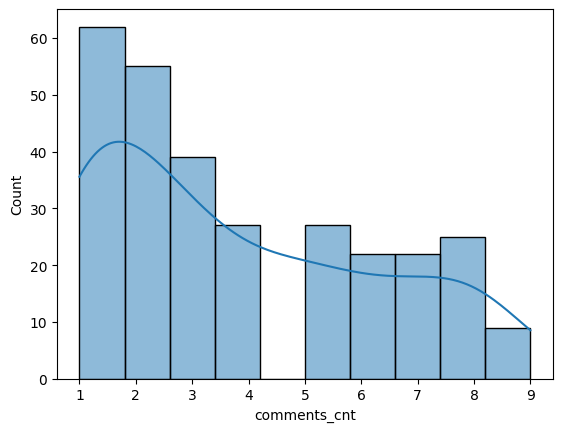

In [20]:
sns.histplot(df.comments_cnt, kde=True)
plt.show()

Здесь у нас пик у 1, далее спад. У большиства, конечно 0 в комментариях. Посмотрим, сколько их.

In [21]:
df.comments_cnt.value_counts(dropna=False)

NaN    320
1.0     62
2.0     55
3.0     39
4.0     27
5.0     27
8.0     25
6.0     22
7.0     22
9.0      9
Name: comments_cnt, dtype: int64

3/4 постов без комментариев.

# repost_cnt - кол-во репостов.

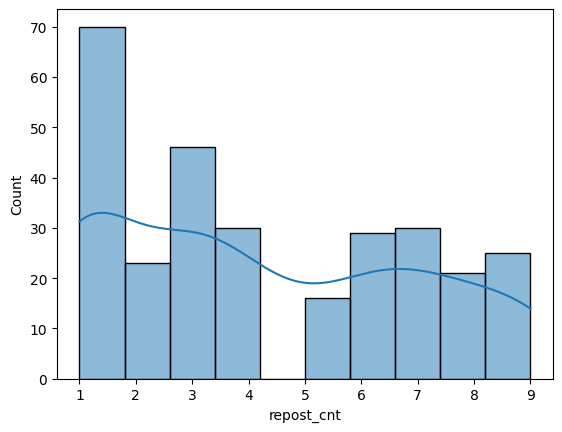

In [22]:
sns.histplot(df.repost_cnt, kde=True)
plt.show()

Здесь у нас пик у 1, далее спад. У большиства, конечно 0 в комментариях. Посмотрим, сколько их.

In [22]:
df.repost_cnt.value_counts(dropna=False)

NaN    318
1.0     70
3.0     46
7.0     30
4.0     30
6.0     29
9.0     25
2.0     23
8.0     21
5.0     16
Name: repost_cnt, dtype: int64

3/4 постов без репостов.

Распределение репостов и комментариев очень похожи. Инетересно посмотреть, как они зависят друг от друга.

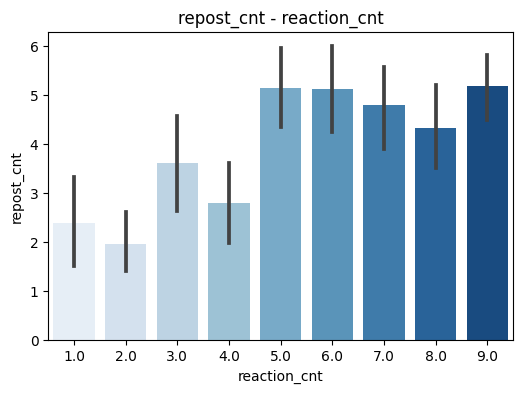

In [24]:
plt.figure(figsize=(6,4))
sns.barplot(x='reaction_cnt', y='repost_cnt', data = df, palette='Blues')
plt.title('repost_cnt - reaction_cnt')
plt.show()

Все также логично, с увеличением кол-ва реакций на пост, увеличивается кол-во тех,к то репостит.

Посмотрим связано ли кол-во репостов с реакциями.

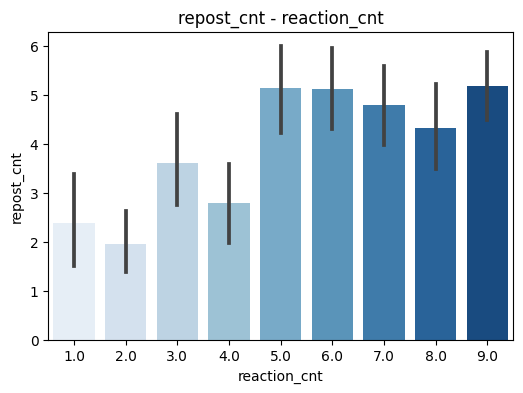

In [23]:
plt.figure(figsize=(6,4))
sns.barplot(x='reaction_cnt', y='repost_cnt', data = df, palette='Blues')
plt.title('repost_cnt - reaction_cnt')
plt.show()

In [24]:
df.head()

,account_link,search_keywords,name,title,works_at,intro,experience,place,posts_cnt,post_text,reaction_cnt,comments_cnt,repost_cnt
1,https://www.linkedin.com/in/rauventa,senior frontend,Ilya Moiseenko,"LOOKING FOR ""Senior/Lead Frontend (React) Deve...",Centicore,"Ilya, React Developer from Moscow.Ilya, React ...",8.0,"Москва, Москва, Россия",1,Я только что получил(а) значок за навык «JavaS...,1.0,NaN,NaN
15,https://www.linkedin.com/in/ny-yakushenko,frontend,Nikolay Yakushenko,Frontend | Full Stack Developer (JavaScript • ...,ООО «АРР»,"Являюсь Fullstack разработчиком, без труда вып...",3.0,"Батайск, Ростовская область, Россия",3,Невозможно представить свою жизнь без знания а...,9.0,6.0,7.0
16,https://www.linkedin.com/in/ny-yakushenko,frontend,Nikolay Yakushenko,Frontend | Full Stack Developer (JavaScript • ...,ООО «АРР»,"Являюсь Fullstack разработчиком, без труда вып...",3.0,"Батайск, Ростовская область, Россия",3,𝟭𝟱 Сильных Артов о психологии и жизни 🧘‍♀️ Нау...,6.0,1.0,6.0
17,https://www.linkedin.com/in/ny-yakushenko,frontend,Nikolay Yakushenko,Frontend | Full Stack Developer (JavaScript • ...,ООО «АРР»,"Являюсь Fullstack разработчиком, без труда вып...",3.0,"Батайск, Ростовская область, Россия",3,"✅Сервисы на базе ИИ ,которые помогут прокачать...",1.0,NaN,1.0
28,https://www.linkedin.com/in/yuriy-smirnov-9088...,lead web developer,Yuriy Smirnov,Frontend developer,Цифровая добыча,Навыки: Vite · Tailwind · TypeScript · Styled ...,15.0,Россия,6,Всем доброго времени суток. В данный момент ра...,7.0,NaN,2.0


Проверим, есть ли в данных рекрутеры.

In [25]:
df[df['title'].str.contains('Recruit')==True]

,account_link,search_keywords,name,title,works_at,intro,experience,place,posts_cnt,post_text,reaction_cnt,comments_cnt,repost_cnt


Есть такие. Посмотрим сколько таких аккаунтов.

In [26]:
len(df[df['title'].str.contains('Recruiter')==True])

0

Почистим данные от рекрутеров.

In [27]:
df = df[df['title'].str.contains('Recruiter')==False]

In [28]:
df.shape

(608, 13)

In [29]:
df.account_link.nunique()

163

Посмотрим на должности наших специалистов.

In [30]:
df.title.unique()

array(['LOOKING FOR "Senior/Lead Frontend (React) Developer" VACANCY',
       'Frontend | Full Stack Developer (JavaScript • TypeScript • React • Redux • NodeJS)',
       'Frontend developer',
       'Frontend Developer (HTML, CSS, JS, React, Redux)',
       'FrontEnd developer. React, Typescript, Redux, MobX, HTML, CSS, JS.',
       'Software frontend engineer',
       'Frontend Developer (JavaScript, React.js, TypeScript)',
       'Frontend developer | React | TS | JS',
       'Frontend Developer React/Next | TypeScript/Javascript(ES6+)',
       'Frontend Engineer - Vue.js, Nuxt, Pinia, Vuex, Quasar, Strapi',
       'Frontend Web (ES6+, React.JS, Node.JS ) Developer',
       'Middle Frontend Developer',
       'Frontend Developer – ООО "АйТи Сервис Менеджмент"',
       'Frontend Разработчик (Vue/React) | Заинтересован в Релокации/Удалённой работе',
       'Frontend Developer', 'Frontend разработчик / HTML - Верстальщик',
       'Frontend Developer experienced in Agile web development

In [31]:
mistakes=['Ищу срочно: Главного геолога (изыскания)! Локация -Москва либо Тольятти', '17000+ | Комплексная помощь в поиске работы | im-konsalting.ru  | mail@im-konsalting.ru | WhatsApp/Telegram: 79643223069',
            'Руководитель подразделений маркетинга и стратегического развития в крупных компаниях на B2C рынке | 11 000+','Строю крутые отделы продаж. Обучаю в формате «Реалити». Я - Владимир Якуба',
            'Специалист по найму персонала – V Kontakte LLC',]
df=df.query('title not in @mistakes')

Итого  наш предобработанный файл:

In [32]:
df.shape

(608, 13)

Это 2039 строк.

In [33]:
df.account_link.nunique()

163

782 уникальных пользователей.

In [34]:
df

,account_link,search_keywords,name,title,works_at,intro,experience,place,posts_cnt,post_text,reaction_cnt,comments_cnt,repost_cnt
1,https://www.linkedin.com/in/rauventa,senior frontend,Ilya Moiseenko,"LOOKING FOR ""Senior/Lead Frontend (React) Deve...",Centicore,"Ilya, React Developer from Moscow.Ilya, React ...",8.0,"Москва, Москва, Россия",1,Я только что получил(а) значок за навык «JavaS...,1.0,NaN,NaN
15,https://www.linkedin.com/in/ny-yakushenko,frontend,Nikolay Yakushenko,Frontend | Full Stack Developer (JavaScript • ...,ООО «АРР»,"Являюсь Fullstack разработчиком, без труда вып...",3.0,"Батайск, Ростовская область, Россия",3,Невозможно представить свою жизнь без знания а...,9.0,6.0,7.0
16,https://www.linkedin.com/in/ny-yakushenko,frontend,Nikolay Yakushenko,Frontend | Full Stack Developer (JavaScript • ...,ООО «АРР»,"Являюсь Fullstack разработчиком, без труда вып...",3.0,"Батайск, Ростовская область, Россия",3,𝟭𝟱 Сильных Артов о психологии и жизни 🧘‍♀️ Нау...,6.0,1.0,6.0
17,https://www.linkedin.com/in/ny-yakushenko,frontend,Nikolay Yakushenko,Frontend | Full Stack Developer (JavaScript • ...,ООО «АРР»,"Являюсь Fullstack разработчиком, без труда вып...",3.0,"Батайск, Ростовская область, Россия",3,"✅Сервисы на базе ИИ ,которые помогут прокачать...",1.0,NaN,1.0
28,https://www.linkedin.com/in/yuriy-smirnov-9088...,lead web developer,Yuriy Smirnov,Frontend developer,Цифровая добыча,Навыки: Vite · Tailwind · TypeScript · Styled ...,15.0,Россия,6,Всем доброго времени суток. В данный момент ра...,7.0,NaN,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2047,https://www.linkedin.com/in/sky3ddd,senior backend,Alex Stakhanov,"Senior Backend Developer – StreamLayer Inc., e...",StreamLayer Inc.,"Currently I use: Typescript, gRPC, TypeORM, Po...",26.0,"Тула, Тульская область, Россия",7,"С удовольствием сообщаю, что я получил(а) новы...",9.0,NaN,NaN
2048,https://www.linkedin.com/in/sky3ddd,senior backend,Alex Stakhanov,"Senior Backend Developer – StreamLayer Inc., e...",StreamLayer Inc.,"Currently I use: Typescript, gRPC, TypeORM, Po...",26.0,"Тула, Тульская область, Россия",7,"С удовольствием сообщаю, что я получил(а) новы...",2.0,1.0,NaN
2050,https://www.linkedin.com/in/sky3ddd,senior backend,Alex Stakhanov,"Senior Backend Developer – StreamLayer Inc., e...",StreamLayer Inc.,"Currently I use: Typescript, gRPC, TypeORM, Po...",26.0,"Тула, Тульская область, Россия",7,"С удовольствием сообщаю, что я получил(а) новы...",1.0,NaN,NaN
2058,https://www.linkedin.com/in/evgenymelnik,senior backend,Evgeny Melnik,software engineer,DzenLab,Головная компания федеральной розничной сети м...,14.0,"Краснодарский край, Россия",2,"Ну что, java рулит :)С начала года в режиме ин...",1.0,3.0,NaN


In [35]:
df.place.unique()

array(['Москва, Москва, Россия', 'Батайск, Ростовская область, Россия',
       'Россия', 'Лобня, Московская область, Россия',
       'Республика Татарстан, Россия',
       'Пушкино, Московская область, Россия',
       'Санкт-Петербург, Санкт-Петербург, Россия',
       'Химки, Московская область, Россия',
       'Рыбинск, Ярославская область, Россия',
       'Москва, Московская область, Россия',
       'Ставрополь, Ставропольский край, Россия',
       'Краснодар, Краснодарский край, Россия', 'Москва, Россия',
       'Пермь, Пермский край, Россия',
       'Ярославль, Ярославская область, Россия',
       'Нижний Новгород, Нижегородская область, Россия',
       'Ростов-на-Дону, Ростовская область, Россия',
       'Екатеринбург, Свердловская область, Россия',
       'Уфа, Республика Башкортостан, Россия',
       'Домодедово, Московская область, Россия',
       'Иваново, Ивановская область, Россия',
       'Московская область, Россия',
       'Никольское, Тверская область, Россия',
       'С

## Подготовка текстов

Токенизацию и лемматизацию текстов.

Устанавливаем либу и качаем русскоязычную модель _ru_core_news_sm_.

In [36]:
model = spacy.load('ru_core_news_sm', disable=['ner', 'parser'])

Складываем все посты в один список

In [37]:
df.post_text.isna().sum()

0

In [38]:
df["post_text"] = df["post_text"].dropna()

In [39]:
df["post_text"]  = df["post_text"] .astype('str')

Посмотрим на кол-во символов в постах.

In [40]:
df["symbols"] = [len(x) for x in df['post_text']]

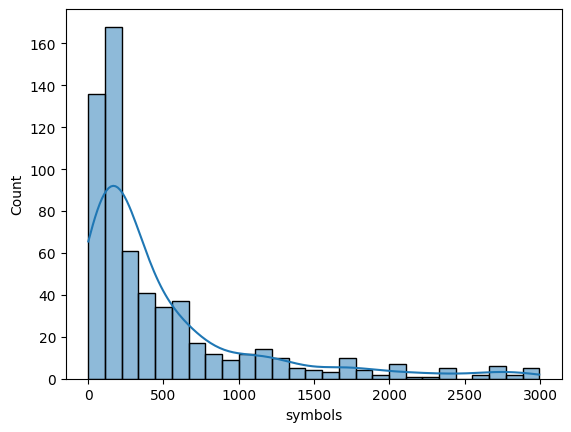

In [41]:
sns.histplot(df.symbols, kde=True)
plt.show()

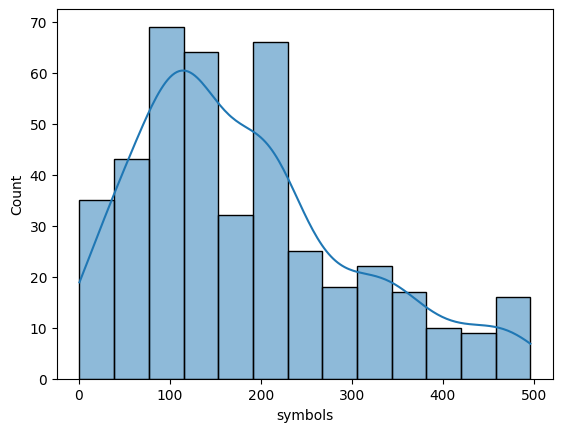

In [42]:
sns.histplot(df[df.symbols<=500].symbols, kde=True)
plt.show()

In [43]:
df[df.symbols<=50]

,account_link,search_keywords,name,title,works_at,intro,experience,place,posts_cnt,post_text,reaction_cnt,comments_cnt,repost_cnt,symbols
71,https://www.linkedin.com/in/valeriy-nepluev-89...,frontend,Valeriy Nepluev,"Frontend Engineer - Vue.js, Nuxt, Pinia, Vuex,...",All3dmodels,Навыки: JavaScript · vue · nuxt · pinia · vuex...,3.0,"Республика Татарстан, Россия",4,К-коварство))),2.0,8.0,1.0,14
77,https://www.linkedin.com/in/oleg-kozlov-4191a0217,frontend,Oleg Kozlov,Middle Frontend Developer,ФГУП Главный радиочастотный центр,I work on Angular. Also created business proje...,3.0,"Москва, Москва, Россия",14,Всем бодрого утра среды!,NaN,NaN,NaN,24
82,https://www.linkedin.com/in/oleg-kozlov-4191a0217,frontend,Oleg Kozlov,Middle Frontend Developer,ФГУП Главный радиочастотный центр,I work on Angular. Also created business proje...,3.0,"Москва, Москва, Россия",14,Жизненно 😁,NaN,NaN,NaN,10
136,https://www.linkedin.com/in/sergeyromanovv,frontend,Sergey Romanov,Frontend Developer experienced in Agile web de...,ATG,"Ищу работу на позицию frontend-разработчика, у...",1.0,Россия,3,#humor#сПросторовИнтернета,7.0,2.0,7.0,26
138,https://www.linkedin.com/in/alenasafronova,frontend,Алена Сафронова,"Frontend Developer (React, Redux, JS)",Ruso,"Стек:Front-end: JS (ES6), React, Redux, TypeSc...",3.0,"Москва, Москва, Россия",2,😁,1.0,NaN,NaN,1
139,https://www.linkedin.com/in/alenasafronova,frontend,Алена Сафронова,"Frontend Developer (React, Redux, JS)",Ruso,"Стек:Front-end: JS (ES6), React, Redux, TypeSc...",3.0,"Москва, Москва, Россия",2,"Что правда, то правда)",5.0,5.0,4.0,23
159,https://www.linkedin.com/in/baremantar,frontend,Timur Asanov,Frontend developer,Affarts,"Hi!My start on frontend ""road"" has begun sprin...",2.0,Россия,3,Шпаргалка по JavaScript #javascript,8.0,1.0,4.0,35
180,https://www.linkedin.com/in/%D0%B0%D0%BB%D0%B5...,frontend,Алексей Риконвальд,Frontend React / Backend .Net Developer,Сейлз-хаус «Газпром-Медиа»,"Хей) Я Fullstack разработчик, на фронтенде раб...",2.0,"Москва, Москва, Россия",3,- Как у вас дела с С++?- Он меня ненавидит.,2.0,NaN,NaN,43
239,https://www.linkedin.com/in/denyacore,backend,Денис Шестиперов,Python Developer | backend,Пилигрим,На предыдущем месте работы утратил интерес к е...,1.0,"Рыбинск, Ярославская область, Россия",8,звучит как план#it #memes #humor,3.0,NaN,1.0,32
240,https://www.linkedin.com/in/denyacore,backend,Денис Шестиперов,Python Developer | backend,Пилигрим,На предыдущем месте работы утратил интерес к е...,1.0,"Рыбинск, Ярославская область, Россия",8,"найди одно маааленькое ""но""#it #memes #humor",1.0,NaN,NaN,44


In [44]:
texts = df["post_text"].tolist()

Выполняем лемматизацию текстов.

In [45]:
res = []
for doc in model.pipe(texts, disable=["tagger", "parser"]):
    res.append([token.lemma_ for token in doc])

In [46]:
with open("lemmas.json", "w") as fid:
    json.dump({"lemmas": res}, fid)

Сохраним результат, чтобы не повторять лемматизацию заново в следующий раз.

Смотрим на результат - случайным образом сэмплируем несколько примеров

In [47]:
", ".join(res[np.random.randint(len(res))])

'занятный, цитата, из, книга, ", человеческий, фактор":“коварный, эффект, текучка, в, том, ,, что, она, порождать, текучка, ., человек, уходить, быстро, ,, поэтому, нет, смысл, тратить, деньга, на, они, обучение, ., поскольку, компания, ничто, не, вкладывать, в, человек, ,, ему, легко, с, она, распрощаться, ., новый, сотрудник, нанимать, не, за, они, превосходный, качество, ,, поскольку, заменить, такой, качество, быть, слишком, сложный, ., ощущение, же, ,, что, компания, не, видеть, в, сотруднике, ничто, необычайный, ,, вызывать, у, этот, сотрудник, чувство, неоцененности, как, индивидуум, ., другие, ,, кстати, ,, постоянно, увольняются, ,, значить, ,, с, вами, что, -, то, не, так, ,, если, вы, ещё, на, год, задержитесь, здесь, ., ”'

In [48]:
", ".join(res[np.random.randint(len(res))])

'здравствовать, ,, я, в, поиск, новый, карьерный, возможность, и, быть, признателен(а, ), за, ваш, поддержка, ., заранее, благодарить, за, весь, рекомендация, контакт, ,, совет, или, возможность, ,, которые, вы, мочь, предложить, ., #, opentowork'

In [49]:
", ".join(res[np.random.randint(len(res))])

'!, !, !, очень, удобный, шпаргалка, по, git, !, !, !, тот, кто, ещё, не, сделать, это, ,, приглашать, подписаться, 👍, на, мой, телеграмм, -, канал, qa, ❤, life, \xa0, https://t.me/QA4Life.Это, канал, для, начинать, 🧑, и, опытный, 🧔, тестировщиков, ,, qa, и, qc, 🧐, ,, а, также, быть, полезный, также, для, po, ,, pm, ,, da, ,, ba, и, sm, специалист, 👨, \u200d, 👩, \u200d, 👦, \u200d, 👦, ., здесь, я, ежедневно, делиться, 🗃, ещё, больший, количество, материал, по, it, 🌐, тематика, (, статья, ,, обучать, видео, ,, новость, ,, ит, -, юмор, ,, опрос, ,, обсуждение, …, )#it, \xa0, #, engineer, \xa0, #, software, \xa0, #, qa, \xa0, #, qc, \xa0, #, quality, \xa0, #, recruiter, \xa0, #, recruiting, \xa0, #, hr, \xa0, #, tester, \xa0, #, qa_engineer, \xa0, #, testing, \xa0, #, pm, \xa0, #, ba, \xa0, #, da, \xa0, #, тестирование, \xa0, #, development, \xa0, #, developer, \xa0\xa0, #, тестировщик, \xa0, #, тестер'



Удалим знаки препинания, цифры и слова, содержащие цифры. Для это соберём регулярное выражение, которое подходит для любого слова, состоящего из букв кирилицы.



In [50]:
word_pattern = re.compile("^[а-яА-ЯёЁ]*$")

In [51]:
def remove_symbols(doc):
    return [token for token in doc if word_pattern.match(token)]

In [52]:
corpus = list(map(remove_symbols, res))

In [53]:
", ".join(corpus[np.random.randint(len(corpus))])

'линкуськины, мой, подруга, зарина, буклова, аналитик, сейчас, в, активный, поиск, прям, мой, личный, рекомендация, ведь, не, имей, рубль, а, имей, друг, которых, мочь, порекомендовать, к, наём, так, гласить, народный, выдумать, мною, премудрость, честной, слово, быть, бы, у, меня, позиция, для, нее, ваще, б, не, отдать, никто, это, человек, который, мочь, изучить, всё, и, весь, в, кратчайшие, срок, всегда, завидовать, этот, навыку, и, всегда, говорить, что, если, зарина, нужный, быть, научиться, конструировать, ракета, или, управлять, трактор, она, просто, взять, пара, день, на, изучение, и, потом, стать, в, это, хороший, ну, псих, в, хороший, смысл, я, кстати, математик, у, нее, в, старший, класс, списывать, потому, что, на, мне, клеймо, гуманитарий, я, без, калькулятор, даже, палец, на, рука, не, считать, зарина, в, поиск, позиция, на, аналитик, данных, налитика, у, нее, более, год, коммерческий, опыт, в, аналитика, отлично, знать, базовый, запрос, на, изучать, сейчас, весь, быть, б

Выглядит гораздо лучше.

## Векторизация текстов

Чтобы уменьшить размерность получаемой матрицы, добавим исключение стоп-слов.

In [54]:
stop_words = stopwords.words('russian')
print(stop_words)

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

In [55]:
tfidf = TfidfVectorizer(stop_words=stop_words, min_df=10, max_df=0.9)

Т.е. TfIdfVectorizer принимает на вход список предложений, поэтому необходимо объединить списки слов, составляющих корпус, в предложения.

In [56]:
docs = [" ".join(tokens) for tokens in corpus]
docs[:3]

['я только что значок за навык кто хотеть быть следующий пройти тест на проверка навык',
 'невозможный представить свой жизнь без знание английский язык и его можно изучить самостоятельно делиться с вами ресурс которые быть полезный для самостоятельный изучение английский язык бесплатный сайт для изучение грамматика прикольный ресурс где вы мочь пообщаться с искуственным интеллект распространить из самых популярный значительно упрощать жизнь при ведение диалог тот кто часто писать отличный ресурса с объяснение правило и шаблон просмотр фильм на английский с субтитрами можно день бесплатно попользовать книжка любитель почитать комикс словарь с толкование слово на английский синоним и даже история возникновение слово прокачка очень рекомендовать слушать радио помогать даже прослушивание на фон научиться понимать речь и усвоите интонация и прокачка восприятие американский речь прокачка восприятие британский речь советовать поглядывать блогер носитель которые в наглядный и яркий форма объя

In [57]:
docs = list(filter(None, docs))

In [58]:
x = tfidf.fit_transform(docs)

In [59]:
x.shape

(476, 275)

Теперь составим словарь {id_токена: токен} - он пригодится нам позднее.

In [60]:
id2word = {i: token for i, token in enumerate(tfidf.get_feature_names_out())}

## LDA

Теперь можем запустить алгоритм LDA. Зададим количество тем равное 5.

In [61]:
n_topics = 5

In [62]:
lda = LatentDirichletAllocation(n_components=n_topics, random_state=31)

In [63]:
topics = lda.fit_transform(x)

In [64]:
topics.shape

(476, 5)

### Ключевые слова

Теперь извлечём ключевые слова для каждой из 5 тем. В свойсте _components_ _ лежит матрица соответствия слов темам. Пройдёмся по каждой из 5 выделенных тем и для каждой возьмём ТОП-20 слов.

По очереди пройдёмся по каждой теме (первое измерение массиа) и выберем ТОП-20 слов, наиболее характерных для этой темы. Потом по индексу слова обратимся к словарю и узнаем, что это за слово.

In [65]:
for i in range(n_topics):
    c = lda.components_[i, :]
    topic_tokens = [id2word.get(token_id) for token_id in np.argsort(c)[-20:]]
    print("Тема",i+1, ":")
    print(", ".join(topic_tokens))
    print("\n ")

Тема 1 :
рад, привет, посмотреть, признателен, новый, ваш, мочь, которые, поиск, весь, здравствовать, предложить, рекомендация, благодарить, карьерный, поддержка, совет, заранее, контакт, возможность

 
Тема 2 :
мочь, наш, поиск, ещё, написать, задача, проект, человек, год, интересный, весь, команда, хороший, очень, свой, работать, опыт, время, это, работа

 
Тема 3 :
репосты, крутой, россия, крупный, привет, пока, проект, резюме, разработчик, позиция, всем, искать, вакансия, новый, компания, начинать, работа, должность, сообщать, удовольствие

 
Тема 4 :
удобный, опытный, ещё, также, делиться, внимание, неделя, материал, который, специалист, бесплатный, знать, предлагать, полезный, тестирование, вопрос, канал, довольно, стать, курс

 
Тема 5 :
автоматизация, которых, свой, дело, других, английский, текст, модель, слово, сделать, изучение, инструмент, хотеть, язык, значок, проверка, тест, пройти, следующий, навык

 


По полученным ключевым словам можно составить представление о содержании той или иной темы. Хотя иногда сочетания слов довольно странные )  

### Типичные статьи

Теперь для каждой темы возьмём по одному документу, который хорошо соответсвует этой теме. Для этого заглянем в массив _topics_.

In [66]:
for i in range(n_topics):
    doc_id = np.argmax(topics[:, i])
    print("Тема ", i)
    print(df.iloc[doc_id]["post_text"])
    print("\n")

Тема  0
Надеюсь кому-нибудь будет полезна данная статья;) 💻


Тема  1
Если вы хотите попробовать крутую генерацию картинок по тексту, то сегодня midjourney раздает бесплатные приглашения к себе в бету!


Тема  2
Парень написал и почти 10 лет поддерживает библиотеку js на которой стоит web-фронтенд всей сети. Отказался от всего и пожертвовал для OpenSource столько, что невозможно и представить. При этом его пинают за то, что он что-то вякает про деньги и за то, что он русский. Черт с ними с Netflix, Ebay, Paypal, Pornhub и всеми остальными веб-сервисами (в буквальном смысле). Неужели у нас нет ни одной компании, которая заберет его к себе под крыло и даст возможность дальше развивать библиотеку на благо всеобщего развития it?Его настолько задолбали, что он написал подробно, что происходитhttps://lnkd.in/eCzhC6WGТут с переводомhttps://lnkd.in/eBtdKPeW#opensource #corejs


Тема  3
Мой основной проект над которым я работал можно посмотреть здесь:


Тема  4
Невозможно представить свою жизнь

Типичные статьи, в целом хорошо согласуются с ключевыми словами, которые мы выделили. Например, первая выделенная тема - про египтологию и археологию.
 В тоже время, мы видим и очень короткие тексты, например 4 и 14. Это подсказывает дальнейшие шаги. Например:
  - удалить из корпуса текстов очень короткие статьи. Чтобы правильно задать порог отсечения, необходимо построить распределение текстов по длине.   - возможно, ключевыми словами, на которые ориентировался алгоритм, стали названия информационных агентств - РБК и ИТАР-ТАСС. Стоит подумать о том, чтобы добавить эти слова в стоп-лист.

А ещё вы всегда можете сделать шаг назад и дополнить модель. Например:
- пополнить список стоп-слов (просмотрите внимательно ключевые слова каждой из тем - нет ли там случайных слов?);
- изменить настройки Tf-idF;
- увеличить/уменьшить количество тем;
- обучать LDA чуть дольше;
- заменить LDA на другой алгоритм тематического моделирояни.

# Полезные ссылки

- [Вики](https://ru.wikipedia.org/wiki/%D0%A2%D0%B5%D0%BC%D0%B0%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%BE%D0%B5_%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5)

- [История о том, как прочитать 120 тысяч анекдотов и не рассмеяться раньше времени](https://habr.com/ru/companies/otus/articles/723306/)

- [Видеоурок "Анализ текстовых данных тематическое моделирование комментариев Вконтакте"](https://www.youtube.com/watch?v=0DnfzQdbwQw)

- [LDA в Sklearn](https://scikit-learn.org/0.16/modules/generated/sklearn.lda.LDA.html)

- [Topic Modeling разными алгоритмами](https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py)

- [Более академическое описание тематического моделировния](http://www.machinelearning.ru/wiki/index.php?title=%D0%A2%D0%B5%D0%BC%D0%B0%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%BE%D0%B5_%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5)